# Roadmap

The goal of this notebook is to provide an example of how to scrape NEXRAD level II data and use pyart and csu_radar_tools to calculate and plot radar rainfall storm total and compute basin average time series

  1. Download available NEXRAD data
  3. Download sounding data
  4. Optionally run QAQC functions to generate mask of bad data
  5. Compute rainfall estimate
  6. Interpolate radially to fill QAQC masked values
  7. Grid rainfall accumulations at each sweep time
  8. Save grids to NetCDF files
  9. Accumulate gridded data
  10. Plot

Before getting started, set up your environment with all the necessities to run this notebook. To create this environment just run **`$ conda env create -f environment.yml`** where **`environment.yml`** is a file containing the following:

In [1]:
!cat environment.yml

name: radar-tools
channels:
- conda-forge
- defaults
dependencies:
- python=2.7
- arm_pyart
- basemap
- basemap-data-hires
- matplotlib
- jupyter
- pandas
- xarray
- numpy
- cython
- wget
- lxml
- pyproj
- pip:
  - skewt
  - git+git://github.com/CSU-Radarmet/CSU_RadarTools.git


## Run and load the rainfall processing functions

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import pyart
from skewt import SkewT
from pyart_radar_tools import *


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


## Download Available Data


In [3]:
ID = 'KICX'

t_start = '2015-09-14 18:00:00'
t_end = '2015-09-15 00:00:00'

paths = data_download(ID, t_start, t_end)

using cached file ...
./tmp/KICX20150914_175628_V06.gz
using cached file ...
./tmp/KICX20150914_180029_V06.gz
using cached file ...
./tmp/KICX20150914_180431_V06.gz
using cached file ...
./tmp/KICX20150914_180832_V06.gz
using cached file ...
./tmp/KICX20150914_181220_V06.gz
using cached file ...
./tmp/KICX20150914_181608_V06.gz
using cached file ...
./tmp/KICX20150914_181957_V06.gz
using cached file ...
./tmp/KICX20150914_182345_V06.gz
using cached file ...
./tmp/KICX20150914_182733_V06.gz
using cached file ...
./tmp/KICX20150914_183122_V06.gz
using cached file ...
./tmp/KICX20150914_183510_V06.gz
using cached file ...
./tmp/KICX20150914_183858_V06.gz
using cached file ...
./tmp/KICX20150914_184246_V06.gz
using cached file ...
./tmp/KICX20150914_184635_V06.gz
using cached file ...
./tmp/KICX20150914_185023_V06.gz
using cached file ...
./tmp/KICX20150914_185411_V06.gz
using cached file ...
./tmp/KICX20150914_185800_V06.gz
using cached file ...
./tmp/KICX20150914_190148_V06.gz
using cach

## Sounding data

Optionally you can get data from a nearby sounding in the UWyo format (i.e., from http://weather.uwyo.edu/upperair/sounding.html), and copy and paste it into a txt file. 



In [4]:
sounding = SkewT.Sounding('./tmp/KFGZ_2015-09-15_00_sounding.txt')

In [5]:
fields = ['rain', 'r_kdp', 'r_z']

## Run
Now, process all the scans between t0 and tn, grid it and accumulate to a storm total

In [6]:
def process_radar(path, sounding, run_QAQC=True,
                  min_dist_km=5, max_dist_km=250,
                  sw_vel=True, max_time_diff=30):
    
    radar = pyart.io.read(path)
    radar = extract_low_sweeps(radar)

    # run some QAQC:
    if run_QAQC:
        start_gate = get_gate_index(radar, dist_km=min_dist_km)
        end_gate = get_gate_index(radar, dist_km=max_dist_km)
        QAQC_mask = construct_QAQC_mask(radar, start_gate, end_gate,
                                        sw_vel=sw_vel,
                                        max_time_diff=max_time_diff)

    # get out just the sweeps with differential phase values
    radar = extract_field_sweeps(radar, field='differential_phase')
    radar = calculate_hidro_rain(radar, sounding)
    radar = calculate_rain_nexrad(radar)
    radar = calculate_rain_kdp(radar)
    if run_QAQC:
        for field in ['rain', 'r_kdp', 'r_z']:
            radar = interpolate_radially(radar, field, QAQC_mask,
                                         start_gate, end_gate)
    return radar

In [ ]:
%%time
nx = 400
ny = 400
sweep_times = []
grid_paths = []

for path in paths:
    print('processing', path)
    radar = process_radar(path, sounding)

    for sweep in range(radar.nsweeps):
        end_sweep_time = get_end_sweep_time(radar, sweep)
        sweep_times.append(end_sweep_time)
        
        # extract sweep
        sweepn = radar.extract_sweeps([sweep])
        
        # grid sweep
        m = pyart.map.grid_from_radars([sweepn], grid_shape=(1, ny, nx),
                                       grid_limits=((0, 10000),
                                                    (-ny/2.*1000, ny/2.*1000),
                                                    (-nx/2.*1000, nx/2.*1000)),
                                       fields=fields)
        if len(sweep_times) == 1:
            continue
        
        # calculate difference between last sweep time and current sweep time
        diff_hours = ((sweep_times[-1] - sweep_times[-2]).seconds)/3600.
        

        for field in fields:
            # weight the data by that difference - converting from rate to accumulation
            m.fields[field]['data'] *= diff_hours
            m.fields[field]['units'] = 'mm'

        t = end_sweep_time.isoformat()[:19]
        t = t.replace('-', '').replace('T', '_').replace(':', '')
        grid_path = './tmp/{ID}{t}_grid.nc'.format(ID=ID, t=t)
        print('writing', grid_path)
        pyart.io.write_grid(grid_path, m, write_point_lon_lat_alt=True)
        grid_paths.append(grid_path)

If you have already done all this gridding and saved the results into netcdf files, you can read all the data in, using only the following commands.

In [13]:
import os

nx = 400
ny = 400

grid_paths = ['./tmp/{f}'.format(f=f) for f in os.listdir('./tmp') if '.nc' in f]

In [14]:
rain = np.zeros((ny, nx))
r_z = np.zeros((ny, nx))
r_kdp = np.zeros((ny, nx))
rain_mask = np.zeros((ny, nx))
r_z_mask = np.zeros((ny, nx))
r_kdp_mask = np.zeros((ny, nx))

for grid_path in grid_paths:
    m = pyart.io.read_grid(grid_path)
    #rain
    rain += np.ma.filled(m.fields['rain']['data'][0], 0)
    rain_mask += m.fields['rain']['data'][0].mask
    #r_z
    r_z += np.ma.filled(m.fields['r_z']['data'][0], 0)
    r_z_mask += m.fields['r_z']['data'][0].mask
    #r_kdp
    r_kdp += np.ma.filled(m.fields['r_kdp']['data'][0], 0)
    r_kdp_mask += m.fields['r_kdp']['data'][0].mask

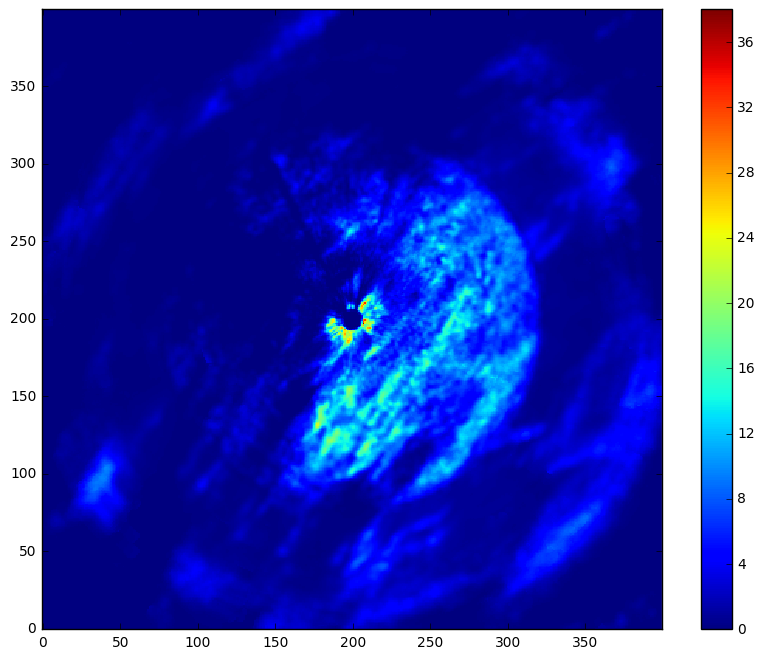

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
c = ax.imshow(rain, origin='lower', interpolation='None', vmin=0)
plt.colorbar(c)
plt.show()

In [16]:
lat = m.point_latitude['data'][0]
lon = m.point_longitude['data'][0]

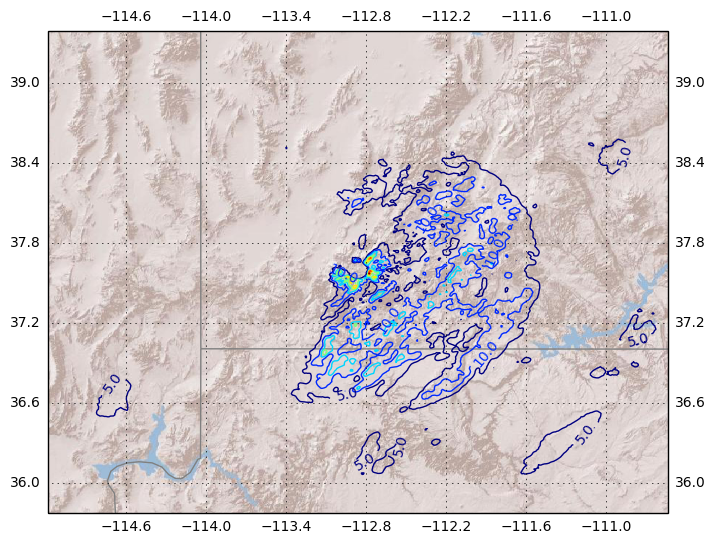

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles

class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
cl = ax.contour(lon, lat, rain)
cl.clabel(fmt='%1.1f')
ax.gridlines(draw_labels=True)
ax.add_image(ShadedReliefESRI(), 8)
ax.add_feature(states_provinces, edgecolor='gray')